# Results on ENCODE ChIP-seq data using JASPAR2014 binding profiles for ChIP'ed TFs with %GC-matched background regions

## Data sets

In [1]:
%config InlineBackend.figure_formats=['svg']
%matplotlib inline
from matplotlib.pyplot import savefig
import pandas as pd
import numpy as np
import os
from scipy.stats import wilcoxon

data = pd.read_csv("data/20150317/wgEncodeAwgTfbs_with_JASPAR_MA.csv", header=0, index_col=0,
                  names=["ENCODE_data_set", "TF_name", "JASPAR_id"])
print "{0:d} ENCODE experiments are considered here".format(len(data)),
print "(i.e. associated to a JASPAR profile)."
print "It corresponds to {0:d} different TFs.".format(len(set(data["TF_name"])))

400 ENCODE experiments are considered here (i.e. associated to a JASPAR profile).
It corresponds to 76 different TFs.


In [2]:
from Bio.motifs.jaspar.db import JASPAR5
# Put the hostname of your local JASPAR database (2014 version was used in our ms)
# along with name, user, and password to access it
jdb = JASPAR5(host='', name='', user='', password='')

In [3]:
def get_tf_family(jasparid):
    motif = jdb.fetch_motif_by_id(jasparid)
    return motif.tf_family

In [4]:
data["TF_family"] = data["JASPAR_id"].map(get_tf_family)

In [5]:
def rename_tf_fam(name):
    if name == "BetaBetaAlpha-zinc finger":
        return "BetaBetaAlpha-zinc Finger"
    elif name == "Ets":
        return "ETS"
    elif name == "Homeo":
        return "Homeodomain"
    elif name == "Leucine-Zipper":
        return "Leucine Zipper"
    elif name == "NF-Y CCAAT-Binding":
        return "NFY CCAAT-binding"
    else:
        return name

In [6]:
print "The number of ChIP-seq experiments associated to each TF family is given below:"
families = {}
for family in data["TF_family"].map(rename_tf_fam):
    if family in families:
        families[family]["all TFs # occurences"] += 1
    else:
        families[family] = {}
        families[family]["all TFs # occurences"] = 1
all_tf_fam_df = pd.DataFrame.from_dict(families, orient='index')
all_tf_fam_df.sort_values("all TFs # occurences", ascending=False)

The number of ChIP-seq experiments associated to each TF family is given below:


,all TFs # occurences
BetaBetaAlpha-zinc Finger,146
Helix-Loop-Helix,56
Leucine Zipper,55
ETS,21
Stat,13
GATA,12
Rel,10
E2F,10
High Mobility Group (Box),8
Forkhead,8


In [7]:
print "TFs are coming from {0:d} different TF families.".format(len(families))

TFs are coming from 24 different TF families.


In [8]:
def auc_val(inline):
    return eval(inline.split(' ')[-1])

In [9]:
# Reading PSSM- and TFFM-based results
rep = '20151103_JasparMatchedChipseqScaledDnashape2ndOrderDimo'
for repo in os.listdir(rep):
    if repo.startswith('wgEncodeAwgTfbs'):
        res_file = '{0}/{1}/predictions_results.txt'.format(rep, repo)
        if os.path.isfile(res_file):
            with open(res_file) as stream:
                first_line = stream.readline()
                assert first_line.startswith('ROC AUC TFFM+DNAshape')
                data.loc[repo, 'TFFM_dnashape_AUROC'] = auc_val(first_line)
                second_line = stream.readline()
                assert second_line.startswith('PR AUC TFFM+DNAshape')
                data.loc[repo, 'TFFM_dnashape_AUPRC'] = auc_val(second_line)
                third_line = stream.readline()
                assert third_line.startswith('ROC AUC TFFM')
                data.loc[repo, 'TFFM_AUROC'] = auc_val(third_line)
                fourth_line = stream.readline()
                assert fourth_line.startswith('PR AUC TFFM')
                data.loc[repo, 'TFFM_AUPRC'] = auc_val(fourth_line)
                fifth_line = stream.readline()
                assert fifth_line.startswith('ROC AUC PWM+DNAshape')
                data.loc[repo, 'PSSM_dnashape_AUROC'] = auc_val(fifth_line)
                sixth_line = stream.readline()
                assert sixth_line.startswith('PR AUC PWM+DNAshape')
                data.loc[repo, 'PSSM_dnashape_AUPRC'] = auc_val(sixth_line)
                seventh_line = stream.readline()
                assert seventh_line.startswith('ROC AUC PWM')
                data.loc[repo, 'PSSM_AUROC'] = auc_val(seventh_line)
                eighth_line = stream.readline()
                assert eighth_line.startswith('PR AUC PWM')
                data.loc[repo, 'PSSM_AUPRC'] = auc_val(eighth_line)
                data.loc[repo, 'TFFM_AUROC_improvement'] = (
                    data.loc[repo, 'TFFM_dnashape_AUROC'] - data.loc[repo, 'TFFM_AUROC'])
                data.loc[repo, 'TFFM_AUPRC_improvement'] = (
                    data.loc[repo, 'TFFM_dnashape_AUPRC'] - data.loc[repo, 'TFFM_AUPRC'])
                data.loc[repo, 'PSSM_AUROC_improvement'] = (
                    data.loc[repo, 'PSSM_dnashape_AUROC'] - data.loc[repo, 'PSSM_AUROC'])
                data.loc[repo, 'PSSM_AUPRC_improvement'] = (
                    data.loc[repo, 'PSSM_dnashape_AUPRC'] - data.loc[repo, 'PSSM_AUPRC'])

In [10]:
# Reading 4-bits-based results
rep = '20160416_JasparMatchedChipseq1merScaledDnashape2ndorderDimoGradboost'
for repo in os.listdir(rep):
    if repo.startswith('wgEncodeAwgTfbs'):
        res_file = '{0}/{1}/predictions_results.txt'.format(rep, repo)
        if os.path.isfile(res_file):
            with open(res_file) as stream:
                first_line = stream.readline()
                assert first_line.startswith('ROC AUC 1mer+DNAshape')
                data.loc[repo, '4bits_dnashape_AUROC'] = auc_val(first_line)
                second_line = stream.readline()
                assert second_line.startswith('PR AUC 1mer+DNAshape')
                data.loc[repo, '4bits_dnashape_AUPRC'] = auc_val(second_line)
                third_line = stream.readline()
                assert third_line.startswith('ROC AUC 1mer')
                data.loc[repo, '4bits_AUROC'] = auc_val(third_line)
                fourth_line = stream.readline()
                assert fourth_line.startswith('PR AUC 1mer')
                data.loc[repo, '4bits_AUPRC'] = auc_val(fourth_line)
                data.loc[repo, '4bits_AUROC_improvement'] = (
                    data.loc[repo, '4bits_dnashape_AUROC'] - data.loc[repo, '4bits_AUROC'])
                data.loc[repo, '4bits_AUPRC_improvement'] = (
                    data.loc[repo, '4bits_dnashape_AUPRC'] - data.loc[repo, '4bits_AUPRC'])
data.TF_family = data.TF_family.map(rename_tf_fam)

## TFFM analyses


### Results on all the ChIP-seq experiments

In [11]:
print "TFFM-based classifiers have higher AUROC in {0:d} over {1:d} cases".format(
    len(data[data["TFFM_dnashape_AUROC"] > data["TFFM_AUROC"]]), len(data.dropna()))
print "TFFM-based classifiers have higher AUPRC in {0:d} over {1:d} cases".format(
    len(data[data["TFFM_dnashape_AUPRC"] > data["TFFM_AUPRC"]]), len(data.dropna()))

TFFM-based classifiers have higher AUROC in 399 over 400 cases
TFFM-based classifiers have higher AUPRC in 396 over 400 cases


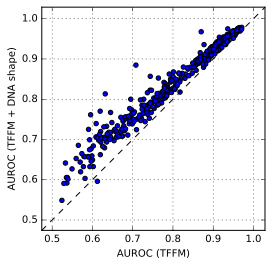

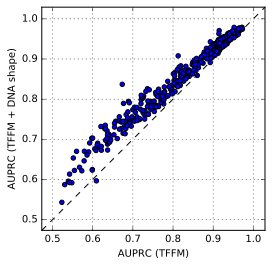

In [12]:
mini = min(min(data.dropna()["TFFM_AUROC"]), min(data.dropna()["TFFM_dnashape_AUROC"])) - 0.05
maxi = max(max(data.dropna()["TFFM_AUROC"]), max(data.dropna()["TFFM_dnashape_AUROC"])) + 0.05
axes = data.dropna().plot(x="TFFM_AUROC", y="TFFM_dnashape_AUROC", kind="scatter")
axes.set_xlabel("AUROC (TFFM)")
axes.set_ylabel("AUROC (TFFM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
axes.grid()
#savefig("AUROC_TFFM_TFFM+DNAshape.svg")

mini = min(min(data.dropna()["TFFM_AUPRC"]), min(data.dropna()["TFFM_dnashape_AUPRC"])) - 0.05
maxi = max(max(data.dropna()["TFFM_AUPRC"]), max(data.dropna()["TFFM_dnashape_AUPRC"])) + 0.05
axes = data.dropna().plot(x="TFFM_AUPRC", y="TFFM_dnashape_AUPRC", kind="scatter")
axes.set_xlabel("AUPRC (TFFM)")
axes.set_ylabel("AUPRC (TFFM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
axes.grid()
#savefig("AUPRC_TFFM_TFFM+DNAshape.svg")

In [13]:
print wilcoxon(data['TFFM_dnashape_AUROC'], data['TFFM_AUROC'])
print wilcoxon(data['TFFM_dnashape_AUPRC'], data['TFFM_AUPRC'])

WilcoxonResult(statistic=57.0, pvalue=4.1887377500020694e-67)
WilcoxonResult(statistic=63.0, pvalue=4.3816324809616283e-67)


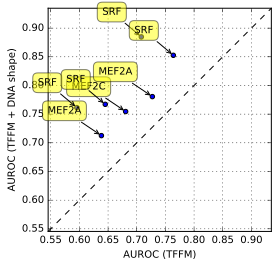

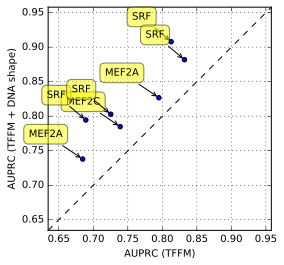

In [14]:
data_mads = data[data.TF_family == 'MADS']
mini = min(min(data_mads["TFFM_AUROC"]), 
           min(data_mads["TFFM_dnashape_AUROC"])) - 0.05
maxi = max(max(data_mads["TFFM_AUROC"]), 
           max(data_mads["TFFM_dnashape_AUROC"])) + 0.05
axes = data_mads.plot(x="TFFM_AUROC", y="TFFM_dnashape_AUROC", kind="scatter")
axes.set_xlabel("AUROC (TFFM)")
axes.set_ylabel("AUROC (TFFM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
axes.grid()
for label, xpos, ypos in zip(data_mads.TF_name, data_mads['TFFM_AUROC'],
                             data_mads['TFFM_dnashape_AUROC']):
    axes.annotate(label, xy=(xpos, ypos), xytext=(-20, 20), textcoords = 'offset points',
                  ha = 'right', va = 'bottom', bbox = dict(boxstyle = 'round,pad=0.5',
                                                           fc = 'yellow', alpha = 0.5),
                  arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
#savefig("ENCODE_MADS_AUROC_TFFM_TFFM+DNAshape.svg")

mini = min(min(data_mads["TFFM_AUPRC"]), 
           min(data_mads["TFFM_dnashape_AUPRC"])) - 0.05
maxi = max(max(data_mads["TFFM_AUPRC"]), 
           max(data_mads["TFFM_dnashape_AUPRC"])) + 0.05
axes = data_mads.plot(x="TFFM_AUPRC", y="TFFM_dnashape_AUPRC", kind="scatter")
axes.set_xlabel("AUPRC (TFFM)")
axes.set_ylabel("AUPRC (TFFM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
axes.grid()
for label, xpos, ypos in zip(data_mads.TF_name, data_mads['TFFM_AUPRC'],
                             data_mads['TFFM_dnashape_AUPRC']):
    axes.annotate(label, xy=(xpos, ypos), xytext=(-20, 20), textcoords = 'offset points',
                  ha = 'right', va = 'bottom', bbox = dict(boxstyle = 'round,pad=0.5',
                                                           fc = 'yellow', alpha = 0.5),
                  arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
#savefig("ENCODE_MADS_AUPRC_TFFM_TFFM+DNAshape.svg")

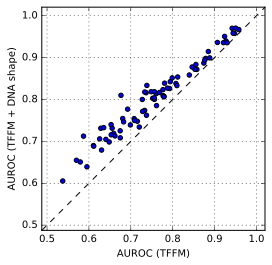

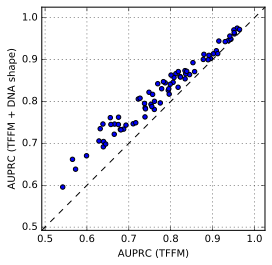

In [15]:
tf_dico = {'TF_name': [], 'TFFM_dnashape_AUROC': [], 'TFFM_AUROC': [],
           'TFFM_dnashape_AUPRC': [], 'TFFM_AUPRC': []}
for tf in list(set(data.TF_name)):
    tf_dico['TF_name'].append(tf)
    tf_dico['TFFM_dnashape_AUROC'].append(
        data.dropna().loc[data.TF_name == tf].TFFM_dnashape_AUROC.median())
    tf_dico['TFFM_AUROC'].append(
        data.dropna().loc[data.TF_name == tf].TFFM_AUROC.median())
    tf_dico['TFFM_dnashape_AUPRC'].append(
        data.dropna().loc[data.TF_name == tf].TFFM_dnashape_AUPRC.median())
    tf_dico['TFFM_AUPRC'].append(
        data.dropna().loc[data.TF_name == tf].TFFM_AUPRC.median())
data_tffm = pd.DataFrame(tf_dico)

mini = min(min(data_tffm['TFFM_AUROC']), min(data_tffm['TFFM_dnashape_AUROC'])) - 0.05
maxi = max(max(data_tffm['TFFM_AUROC']), max(data_tffm['TFFM_dnashape_AUROC'])) + 0.05
axes = data_tffm.dropna().plot(x='TFFM_AUROC', y='TFFM_dnashape_AUROC', kind='scatter')
axes.set_xlabel("AUROC (TFFM)")
axes.set_ylabel("AUROC (TFFM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
axes.grid()
#savefig('AUROC_TFFM_TFFM+DNAshape_perTF.svg')

mini = min(min(data_tffm['TFFM_AUPRC']), min(data_tffm['TFFM_dnashape_AUPRC'])) - 0.05
maxi = max(max(data_tffm['TFFM_AUPRC']), max(data_tffm['TFFM_dnashape_AUPRC'])) + 0.05
axes = data_tffm.dropna().plot(x='TFFM_AUPRC', y='TFFM_dnashape_AUPRC', kind='scatter')
axes.set_xlabel("AUPRC (TFFM)")
axes.set_ylabel("AUPRC (TFFM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
axes.grid()
#savefig('AUPRC_TFFM_TFFM+DNAshape_perTF.svg')

In [16]:
print wilcoxon(data_tffm['TFFM_dnashape_AUROC'], data_tffm['TFFM_AUROC'])
print wilcoxon(data_tffm['TFFM_dnashape_AUPRC'], data_tffm['TFFM_AUPRC'])

WilcoxonResult(statistic=0.0, pvalue=3.6060528034893936e-14)
WilcoxonResult(statistic=0.0, pvalue=3.6060528034893936e-14)


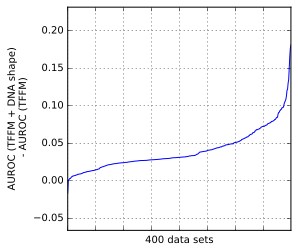

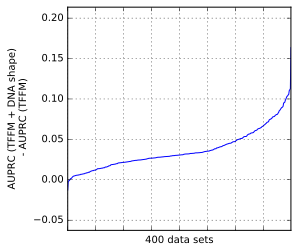

In [17]:
data = data.sort_values("TFFM_AUROC_improvement")
axes = data.dropna().plot(y="TFFM_AUROC_improvement", use_index=False, legend=False)
axes.tick_params(axis="x", labelbottom='off')
axes.set_xlabel("{0:d} data sets".format(len(data.dropna())))
axes.set_ylabel("AUROC (TFFM + DNA shape)\n - AUROC (TFFM)")
axes.set_ylim(min(data.TFFM_AUROC_improvement) - 0.05,
              max(data.TFFM_AUROC_improvement) + 0.05)
axes.set_aspect(1./axes.get_data_ratio())
axes.grid()
#savefig("AUROC_improvement_TFFM_TFFM+DNAshape.svg")

data = data.sort_values("TFFM_AUPRC_improvement")
axes = data.dropna().plot(y="TFFM_AUPRC_improvement", use_index=False, legend=False)
axes.tick_params(axis="x", labelbottom='off')
axes.set_xlabel("{0:d} data sets".format(len(data.dropna())))
axes.set_ylabel("AUPRC (TFFM + DNA shape)\n - AUPRC (TFFM)")
axes.set_ylim(min(data.TFFM_AUPRC_improvement) - 0.05,
              max(data.TFFM_AUPRC_improvement) + 0.05)
axes.set_aspect(1./axes.get_data_ratio())
axes.grid()
#savefig("AUPRC_improvement_TFFM_TFFM+DNAshape.svg")

In [18]:
%load_ext rpy2.ipython

In [19]:
families_list = families.keys()

In [20]:
%%R -i data -i families_list -o families_mww
data = as.data.frame(data)
families_mww = data.frame(row.names=families_list)
for(family in families_list){
    inside = data[data['TF_family'] == family, 'TFFM_AUROC_improvement'];
    outside = data[data['TF_family'] != family, 'TFFM_AUROC_improvement'];
    mww = wilcox.test(inside, outside, alternative='g', exact=TRUE);
    families_mww[family, 'mww_pval'] = mww$p.value;
    families_mww[family, 'mww_corrected'] = mww$p.value * length(families_list);
    families_mww[family, 'family'] = family
}

In [21]:
families_mww_df = pd.DataFrame(families_mww[['mww_pval', 'mww_corrected']])
families_mww_df.index = families_list
families_mww_df.sort_values('mww_corrected')

,mww_pval,mww_corrected
E2F,0.000022,0.000530
MADS,0.000048,0.001146
Homeodomain,0.000956,0.022943
Other,0.002253,0.054061
TATA-binding,0.003105,0.074523
IRF,0.003150,0.075591
RFX,0.010067,0.241598
Rel,0.019263,0.462305
NFI CCAAT-binding,0.034534,0.828825
High Mobility Group (Box),0.035252,0.846043


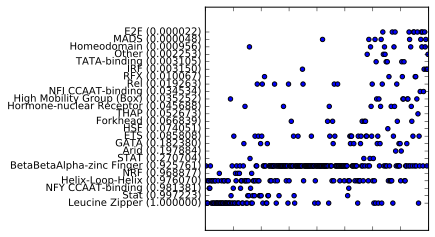

In [22]:
import matplotlib.pyplot as plt
data.loc[:, 'indx'] = range(len(data))
sorted_families = families_mww_df.sort_values('mww_corrected').index
ypos = -1
labels = ['{0} ({1:f})'.format(fam, families_mww_df.loc[fam].mww_pval)
          for fam in sorted_families]
fig = plt.figure()
axes = fig.add_subplot(111)
for family in sorted_families:
    xpos = list(data[data.TF_family == family]['indx'])
    axes.scatter(xpos, [ypos] * len(xpos))
    ypos -= 0.3
axes.set_xlim(0, len(data))
plt.yticks(np.arange(-1, -1 - 0.3 * len(sorted_families), -0.3), labels)
axes.set_aspect(1./axes.get_data_ratio())
axes.tick_params(axis="x", labelbottom='off')
#savefig("AUROC_improvement_TFFM_TFFM+DNAshape_families.svg")

In [23]:
%%R -i data -i families_list -o families_mww
data = as.data.frame(data)
families_mww = data.frame(row.names=families_list)
for(family in families_list){
    inside = data[data['TF_family'] == family, 'TFFM_AUPRC_improvement'];
    outside = data[data['TF_family'] != family, 'TFFM_AUPRC_improvement'];
    mww = wilcox.test(inside, outside, alternative='g', exact=TRUE);
    families_mww[family, 'mww_pval'] = mww$p.value;
    families_mww[family, 'mww_corrected'] = mww$p.value * length(families_list);
    families_mww[family, 'family'] = family
}

In [24]:
families_mww_df = pd.DataFrame(families_mww[['mww_pval', 'mww_corrected']])
families_mww_df.index = families_list
families_mww_df.sort_values('mww_corrected')

,mww_pval,mww_corrected
E2F,0.000002,0.000052
MADS,0.002014,0.048329
High Mobility Group (Box),0.003295,0.079087
Homeodomain,0.004720,0.113291
TATA-binding,0.004765,0.114356
IRF,0.007332,0.175971
Other,0.010439,0.250544
NFI CCAAT-binding,0.010486,0.251667
RFX,0.017272,0.414534
Arid,0.036451,0.874824


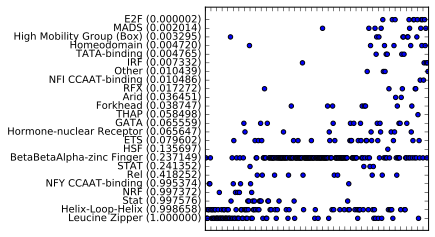

In [25]:
import matplotlib.pyplot as plt
data.loc[:, 'indx'] = range(len(data))
sorted_families = families_mww_df.sort_values('mww_corrected').index
ypos = -1
labels = ['{0} ({1:f})'.format(fam, families_mww_df.loc[fam].mww_pval)
          for fam in sorted_families]
fig = plt.figure()
axes = fig.add_subplot(111)
plt.yticks(np.arange(-1, -1 - 0.3 * len(sorted_families), -0.3), labels)
plt.xticks(range(0, len(data), 10), [])
for family in sorted_families:
    xpos = list(data[data.TF_family == family]['indx'])
    axes.scatter(xpos, [ypos] * len(xpos))
    ypos -= 0.3
axes.set_xlim(0, len(data))
axes.set_aspect(1./axes.get_data_ratio())
#savefig("AUPRC_improvement_TFFM_TFFM+DNAshape_families.svg")

## PSSM analyses

### Results on all the ChIP-seq experiments

In [26]:
print "PSSM-based classifiers have higher AUROC in {0:d} over {1:d} cases".format(
    len(data[data["PSSM_dnashape_AUROC"] > data["PSSM_AUROC"]]), len(data.dropna()))
print "PSSM-based classifiers have higher AUPRC in {0:d} over {1:d} cases".format(
    len(data[data["PSSM_dnashape_AUPRC"] > data["PSSM_AUPRC"]]), len(data.dropna()))

PSSM-based classifiers have higher AUROC in 400 over 400 cases
PSSM-based classifiers have higher AUPRC in 400 over 400 cases


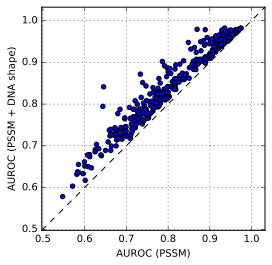

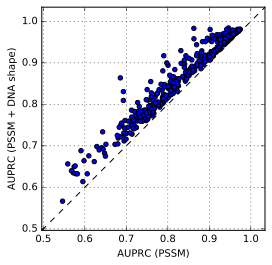

In [27]:
mini = min(min(data.dropna()["PSSM_AUROC"]), min(data.dropna()["PSSM_dnashape_AUROC"])) - 0.05
maxi = max(max(data["PSSM_AUROC"]), max(data["PSSM_dnashape_AUROC"])) + 0.05
axes = data.dropna().plot(x="PSSM_AUROC", y="PSSM_dnashape_AUROC", kind="scatter")
axes.set_xlabel("AUROC (PSSM)")
axes.set_ylabel("AUROC (PSSM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
axes.grid()
#savefig("AUROC_PSSM_PSSM+DNAshape.svg")

mini = min(min(data["PSSM_AUPRC"]), min(data["PSSM_dnashape_AUPRC"])) - 0.05
maxi = max(max(data["PSSM_AUPRC"]), max(data["PSSM_dnashape_AUPRC"])) + 0.05
axes = data.dropna().plot(x="PSSM_AUPRC", y="PSSM_dnashape_AUPRC", kind="scatter")
axes.set_xlabel("AUPRC (PSSM)")
axes.set_ylabel("AUPRC (PSSM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
axes.grid()
#savefig("AUPRC_PSSM_PSSM+DNAshape.svg")

In [28]:
print wilcoxon(data['PSSM_dnashape_AUROC'], data['PSSM_AUROC'])
print wilcoxon(data['PSSM_dnashape_AUPRC'], data['PSSM_AUPRC'])

WilcoxonResult(statistic=0.0, pvalue=2.73006926195335e-67)
WilcoxonResult(statistic=0.0, pvalue=2.73006926195335e-67)


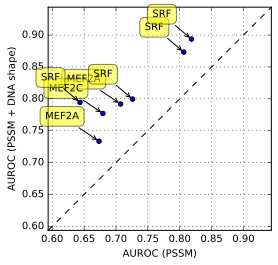

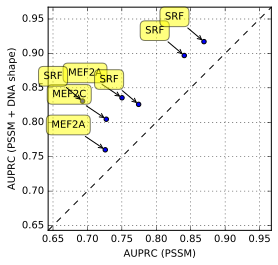

In [29]:
data_mads = data[data.TF_family == 'MADS']
mini = min(min(data_mads["PSSM_AUROC"]), 
           min(data_mads["PSSM_dnashape_AUROC"])) - 0.05
maxi = max(max(data_mads["PSSM_AUROC"]), 
           max(data_mads["PSSM_dnashape_AUROC"])) + 0.05
axes = data_mads.plot(x="PSSM_AUROC", y="PSSM_dnashape_AUROC", kind="scatter")
axes.set_xlabel("AUROC (PSSM)")
axes.set_ylabel("AUROC (PSSM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
axes.grid()
for label, xpos, ypos in zip(data_mads.TF_name, data_mads['PSSM_AUROC'],
                             data_mads['PSSM_dnashape_AUROC']):
    axes.annotate(label, xy=(xpos, ypos), xytext=(-20, 20), textcoords = 'offset points',
                  ha = 'right', va = 'bottom', bbox = dict(boxstyle = 'round,pad=0.5',
                                                           fc = 'yellow', alpha = 0.5),
                  arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
#savefig("ENCODE_MADS_AUROC_PSSM_PSSM+DNAshape.svg")

mini = min(min(data_mads["PSSM_AUPRC"]), 
           min(data_mads["PSSM_dnashape_AUPRC"])) - 0.05
maxi = max(max(data_mads["PSSM_AUPRC"]), 
           max(data_mads["PSSM_dnashape_AUPRC"])) + 0.05
axes = data_mads.plot(x="PSSM_AUPRC", y="PSSM_dnashape_AUPRC", kind="scatter")
axes.set_xlabel("AUPRC (PSSM)")
axes.set_ylabel("AUPRC (PSSM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
axes.grid()
for label, xpos, ypos in zip(data_mads.TF_name, data_mads['PSSM_AUPRC'],
                             data_mads['PSSM_dnashape_AUPRC']):
    axes.annotate(label, xy=(xpos, ypos), xytext=(-20, 20), textcoords = 'offset points',
                  ha = 'right', va = 'bottom', bbox = dict(boxstyle = 'round,pad=0.5',
                                                           fc = 'yellow', alpha = 0.5),
                  arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
#savefig("ENCODE_MADS_AUPRC_PSSM_PSSM+DNAshape.svg")

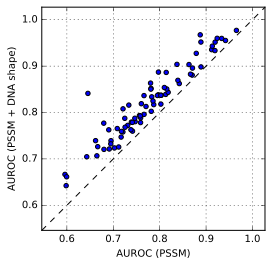

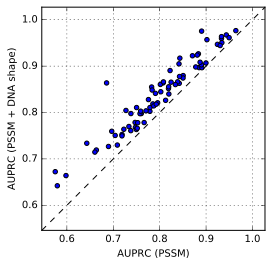

In [30]:
tf_dico = {'TF_name': [], 'PSSM_dnashape_AUROC': [], 'PSSM_AUROC': [],
          'PSSM_dnashape_AUPRC': [], 'PSSM_AUPRC': []}
for tf in list(set(data.TF_name)):
    tf_dico['TF_name'].append(tf)
    tf_dico['PSSM_dnashape_AUROC'].append(
        data.dropna().loc[data.TF_name == tf].PSSM_dnashape_AUROC.median())
    tf_dico['PSSM_AUROC'].append(
        data.dropna().loc[data.TF_name == tf].PSSM_AUROC.median())
    tf_dico['PSSM_dnashape_AUPRC'].append(
        data.dropna().loc[data.TF_name == tf].PSSM_dnashape_AUPRC.median())
    tf_dico['PSSM_AUPRC'].append(
        data.dropna().loc[data.TF_name == tf].PSSM_AUPRC.median())
data_pssm = pd.DataFrame(tf_dico)

mini = min(min(data_pssm.PSSM_AUROC), min(data_pssm.PSSM_dnashape_AUROC)) - 0.05
maxi = max(max(data_pssm.PSSM_AUROC), max(data_pssm.PSSM_dnashape_AUROC)) + 0.05
axes = data_pssm.dropna().plot(x='PSSM_AUROC', y='PSSM_dnashape_AUROC', kind='scatter')
axes.set_xlabel("AUROC (PSSM)")
axes.set_ylabel("AUROC (PSSM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
axes.grid()
#savefig('AUROC_PSSM_PSSM+DNAshape_perTF.svg')

mini = min(min(data_pssm.PSSM_AUROC), min(data_pssm.PSSM_dnashape_AUROC)) - 0.05
maxi = max(max(data_pssm.PSSM_AUROC), max(data_pssm.PSSM_dnashape_AUROC)) + 0.05
axes = data_pssm.dropna().plot(x='PSSM_AUPRC', y='PSSM_dnashape_AUPRC', kind='scatter')
axes.set_xlabel("AUPRC (PSSM)")
axes.set_ylabel("AUPRC (PSSM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
axes.grid()
#savefig('AUPRC_PSSM_PSSM+DNAshape_perTF.svg')

In [31]:
print wilcoxon(data_pssm['PSSM_dnashape_AUROC'], data_pssm['PSSM_AUROC'])
print wilcoxon(data_pssm['PSSM_dnashape_AUPRC'], data_pssm['PSSM_AUPRC'])

WilcoxonResult(statistic=0.0, pvalue=3.6060528034893936e-14)
WilcoxonResult(statistic=0.0, pvalue=3.6060528034893936e-14)


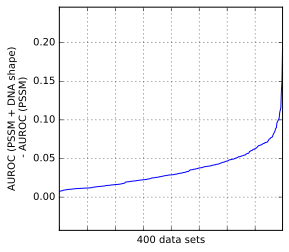

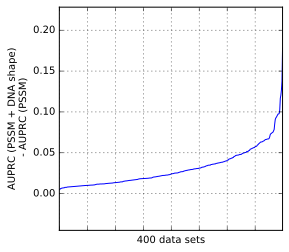

In [32]:
data = data.sort_values("PSSM_AUROC_improvement")
axes = data.dropna().plot(y="PSSM_AUROC_improvement", use_index=False, legend=False)
axes.tick_params(axis="x", labelbottom='off')
axes.set_xlabel("{0:d} data sets".format(len(data.dropna())))
axes.set_ylabel("AUROC (PSSM + DNA shape)\n - AUROC (PSSM)")
axes.set_ylim(min(data.PSSM_AUROC_improvement) - 0.05,
              max(data.PSSM_AUROC_improvement) + 0.05)
axes.set_aspect(1./axes.get_data_ratio())
axes.grid()
#savefig("AUROC_improvement_PSSM_PSSM+DNAshape.svg")

data = data.sort_values("PSSM_AUPRC_improvement")
axes = data.dropna().plot(y="PSSM_AUPRC_improvement", use_index=False, legend=False)
axes.tick_params(axis="x", labelbottom='off')
axes.set_xlabel("{0:d} data sets".format(len(data.dropna())))
axes.set_ylabel("AUPRC (PSSM + DNA shape)\n - AUPRC (PSSM)")
axes.set_ylim(min(data.PSSM_AUPRC_improvement) - 0.05,
              max(data.PSSM_AUPRC_improvement) + 0.05)
axes.set_aspect(1./axes.get_data_ratio())
axes.grid()
#savefig("AUPRC_improvement_PSSM_PSSM+DNAshape.svg")

In [33]:
%%R -i data -i families_list -o families_mww
data = as.data.frame(data)
families_mww = data.frame(row.names=families_list)
for(family in families_list){
    inside = data[data['TF_family'] == family, 'PSSM_AUROC_improvement'];
    outside = data[data['TF_family'] != family, 'PSSM_AUROC_improvement'];
    mww = wilcox.test(inside, outside, alternative='g', exact=TRUE);
    families_mww[family, 'mww_pval'] = mww$p.value;
    families_mww[family, 'mww_corrected'] = mww$p.value * length(families_list);
    families_mww[family, 'family'] = family
}

In [34]:
families_mww_df = pd.DataFrame(families_mww[['mww_pval', 'mww_corrected']])
families_mww_df.index = families_list
families_mww_df.sort_values('mww_corrected')

,mww_pval,mww_corrected
MADS,3.950765e-07,0.000009
Other,1.068714e-03,0.025649
Rel,1.611949e-03,0.038687
E2F,2.012125e-03,0.048291
NRF,2.201397e-03,0.052834
HSF,2.500000e-03,0.060000
TATA-binding,2.798782e-03,0.067171
NFY CCAAT-binding,3.650170e-03,0.087604
IRF,4.424642e-03,0.106191
Homeodomain,6.294927e-03,0.151078


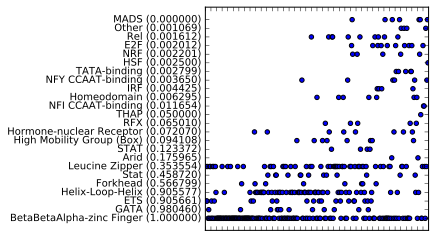

In [35]:
import matplotlib.pyplot as plt
data.loc[:, 'indx'] = range(len(data))
sorted_families = families_mww_df.sort_values('mww_corrected').index
ypos = -1
labels = ['{0} ({1:f})'.format(fam, families_mww_df.loc[fam].mww_pval)
          for fam in sorted_families]
fig = plt.figure()
axes = fig.add_subplot(111)
plt.yticks(np.arange(-1, -1 - 0.3 * len(sorted_families), -0.3), labels)
plt.xticks(range(0, len(data), 10), [])
for family in sorted_families:
    xpos = list(data[data.TF_family == family]['indx'])
    axes.scatter(xpos, [ypos] * len(xpos))
    ypos -= 0.3
plt.xlim(0, len(data))
axes.set_aspect(1./axes.get_data_ratio())
#savefig("AUROC_improvement_PSSM_PSSM+DNAshape_families.svg")

In [36]:
%%R -i data -i families_list -o families_mww
data = as.data.frame(data)
families_mww = data.frame(row.names=families_list)
for(family in families_list){
    inside = data[data['TF_family'] == family, 'PSSM_AUPRC_improvement'];
    outside = data[data['TF_family'] != family, 'PSSM_AUPRC_improvement'];
    mww = wilcox.test(inside, outside, alternative='g', exact=TRUE);
    families_mww[family, 'mww_pval'] = mww$p.value;
    families_mww[family, 'mww_corrected'] = mww$p.value * length(families_list);
    families_mww[family, 'family'] = family
}

In [37]:
families_mww_df = pd.DataFrame(families_mww[['mww_pval', 'mww_corrected']])
families_mww_df.index = families_list
families_mww_df.sort_values('mww_corrected')

,mww_pval,mww_corrected
E2F,0.000033,0.000786
MADS,0.000086,0.002068
TATA-binding,0.000332,0.007978
Other,0.000509,0.012212
NFI CCAAT-binding,0.000802,0.019248
HSF,0.002500,0.060000
NFY CCAAT-binding,0.006561,0.157460
NRF,0.009090,0.218162
IRF,0.011444,0.274660
Homeodomain,0.016060,0.385448


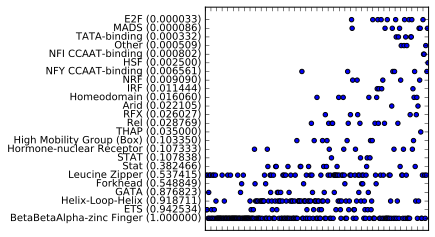

In [38]:
import matplotlib.pyplot as plt
data.loc[:, 'indx'] = range(len(data))
sorted_families = families_mww_df.sort_values('mww_corrected').index
ypos = -1
labels = ['{0} ({1:f})'.format(fam, families_mww_df.loc[fam].mww_pval)
          for fam in sorted_families]
fig = plt.figure()
axes = fig.add_subplot(111)
plt.yticks(np.arange(-1, -1 - 0.3 * len(sorted_families), -0.3), labels)
plt.xticks(range(0, len(data), 10), [])
for family in sorted_families:
    xpos = list(data[data.TF_family == family]['indx'])
    axes.scatter(xpos, [ypos] * len(xpos))
    ypos -= 0.3
plt.xlim(0, len(data))
axes.set_aspect(1./axes.get_data_ratio())
#savefig("AUPRC_improvement_PSSM_PSSM+DNAshape_families.svg")

## 4-bits analyses

### Results on all the ChIP-seq experiments

In [39]:
print "4bits-based classifiers have higher AUROC in {0:d} over {1:d} cases".format(
    len(data[data["4bits_dnashape_AUROC"] > data["4bits_AUROC"]]), len(data.dropna()))
print "4bits-based classifiers have higher AUPRC in {0:d} over {1:d} cases".format(
    len(data[data["4bits_dnashape_AUPRC"] > data["4bits_AUPRC"]]), len(data.dropna()))

4bits-based classifiers have higher AUROC in 362 over 400 cases
4bits-based classifiers have higher AUPRC in 365 over 400 cases


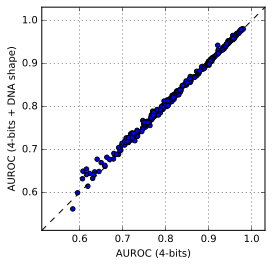

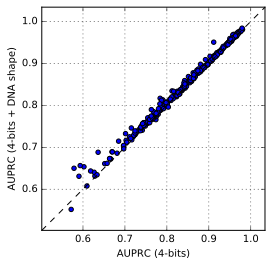

In [40]:
mini = min(min(data.dropna()["4bits_AUROC"]), 
           min(data.dropna()["4bits_dnashape_AUROC"])) - 0.05
maxi = max(max(data.dropna()["4bits_AUROC"]), 
           max(data.dropna()["4bits_dnashape_AUROC"])) + 0.05
axes = data.dropna().plot(x="4bits_AUROC", y="4bits_dnashape_AUROC", kind="scatter")
axes.set_xlabel("AUROC (4-bits)")
axes.set_ylabel("AUROC (4-bits + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
axes.grid()
#savefig("AUROC_4bits_4bits+DNAshape.svg")

mini = min(min(data.dropna()["4bits_AUPRC"]),
           min(data.dropna()["4bits_dnashape_AUPRC"])) - 0.05
maxi = max(max(data.dropna()["4bits_AUPRC"]),
           max(data.dropna()["4bits_dnashape_AUPRC"])) + 0.05
axes = data.dropna().plot(x="4bits_AUPRC", y="4bits_dnashape_AUPRC", kind="scatter")
axes.set_xlabel("AUPRC (4-bits)")
axes.set_ylabel("AUPRC (4-bits + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
axes.grid()
#savefig("AUPRC_4bits_4bits+DNAshape.svg")

In [41]:
print wilcoxon(data['4bits_dnashape_AUROC'], data['4bits_AUROC'])
print wilcoxon(data['4bits_dnashape_AUPRC'], data['4bits_AUPRC'])

WilcoxonResult(statistic=4584.5, pvalue=3.5480734741445133e-53)
WilcoxonResult(statistic=3187.5, pvalue=2.6861545464118576e-57)


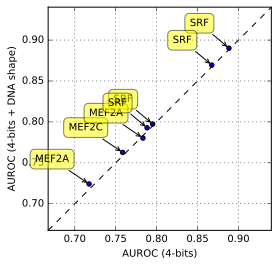

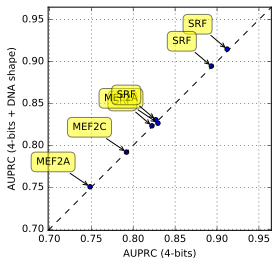

In [42]:
data_mads = data[data.TF_family == 'MADS']
mini = min(min(data_mads["4bits_AUROC"]), 
           min(data_mads["4bits_dnashape_AUROC"])) - 0.05
maxi = max(max(data_mads["4bits_AUROC"]), 
           max(data_mads["4bits_dnashape_AUROC"])) + 0.05
axes = data_mads.plot(x="4bits_AUROC", y="4bits_dnashape_AUROC", kind="scatter")
axes.set_xlabel("AUROC (4-bits)")
axes.set_ylabel("AUROC (4-bits + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
axes.grid()
for label, xpos, ypos in zip(data_mads.TF_name, data_mads['4bits_AUROC'],
                             data_mads['4bits_dnashape_AUROC']):
    axes.annotate(label, xy=(xpos, ypos), xytext=(-20, 20), textcoords = 'offset points',
                  ha = 'right', va = 'bottom', bbox = dict(boxstyle = 'round,pad=0.5',
                                                           fc = 'yellow', alpha = 0.5),
                  arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
#savefig("ENCODE_MADS_AUROC_4bits_4bits+DNAshape.svg")

mini = min(min(data_mads["4bits_AUPRC"]), 
           min(data_mads["4bits_dnashape_AUPRC"])) - 0.05
maxi = max(max(data_mads["4bits_AUPRC"]), 
           max(data_mads["4bits_dnashape_AUPRC"])) + 0.05
axes = data_mads.plot(x="4bits_AUPRC", y="4bits_dnashape_AUPRC", kind="scatter")
axes.set_xlabel("AUPRC (4-bits)")
axes.set_ylabel("AUPRC (4-bits + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
axes.grid()
for label, xpos, ypos in zip(data_mads.TF_name, data_mads['4bits_AUPRC'],
                             data_mads['4bits_dnashape_AUPRC']):
    axes.annotate(label, xy=(xpos, ypos), xytext=(-20, 20), textcoords = 'offset points',
                  ha = 'right', va = 'bottom', bbox = dict(boxstyle = 'round,pad=0.5',
                                                           fc = 'yellow', alpha = 0.5),
                  arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
#savefig("ENCODE_MADS_AUPRC_4bits_4bits+DNAshape.svg")

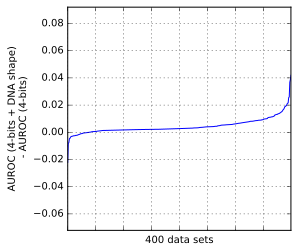

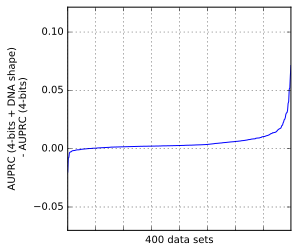

In [43]:
data = data.sort_values("4bits_AUROC_improvement")
axes = data.dropna().plot(y="4bits_AUROC_improvement", use_index=False, legend=False)
axes.tick_params(axis="x", labelbottom='off')
axes.set_xlabel("{0:d} data sets".format(len(data.dropna())))
axes.set_ylabel("AUROC (4-bits + DNA shape)\n - AUROC (4-bits)")
axes.set_ylim(min(data['4bits_AUROC_improvement']) - 0.05,
              max(data['4bits_AUROC_improvement']) + 0.05)
axes.set_aspect(1./axes.get_data_ratio())
axes.grid()
#savefig("AUROC_improvement_4bits_4bits+DNAshape.svg")

data = data.sort_values("4bits_AUPRC_improvement")
axes = data.dropna().plot(y="4bits_AUPRC_improvement", use_index=False, legend=False)
axes.tick_params(axis="x", labelbottom='off')
axes.set_xlabel("{0:d} data sets".format(len(data.dropna())))
axes.set_ylabel("AUPRC (4-bits + DNA shape)\n - AUPRC (4-bits)")
axes.set_ylim(min(data['4bits_AUPRC_improvement']) - 0.05,
              max(data['4bits_AUPRC_improvement']) + 0.05)
axes.set_aspect(1./axes.get_data_ratio())
axes.grid()
#savefig("AUPRC_improvement_4bits_4bits+DNAshape.svg")

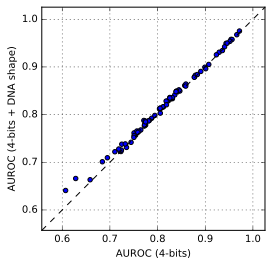

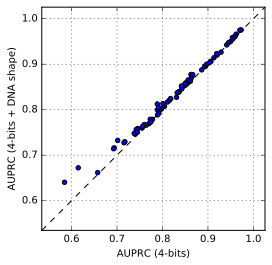

In [44]:
tf_dico = {'TF_name': [], '4bits_dnashape_AUROC': [], '4bits_AUROC': [],
          '4bits_dnashape_AUPRC': [], '4bits_AUPRC': []}
for tf in list(set(data.TF_name)):
    tf_dico['TF_name'].append(tf)
    tf_dico['4bits_dnashape_AUROC'].append(
        data.dropna().loc[data.TF_name == tf]['4bits_dnashape_AUROC'].median())
    tf_dico['4bits_AUROC'].append(
        data.dropna().loc[data.TF_name == tf]['4bits_AUROC'].median())
    tf_dico['4bits_dnashape_AUPRC'].append(
        data.dropna().loc[data.TF_name == tf]['4bits_dnashape_AUPRC'].median())
    tf_dico['4bits_AUPRC'].append(
        data.dropna().loc[data.TF_name == tf]['4bits_AUPRC'].median())
data_1mer = pd.DataFrame(tf_dico)

mini = min(min(data_1mer['4bits_AUROC']), min(data_1mer['4bits_dnashape_AUROC'])) - 0.05
maxi = max(max(data_1mer['4bits_AUROC']), max(data_1mer['4bits_dnashape_AUROC'])) + 0.05
axes = data_1mer.dropna().plot(x='4bits_AUROC', y='4bits_dnashape_AUROC', kind='scatter')
axes.set_xlabel("AUROC (4-bits)")
axes.set_ylabel("AUROC (4-bits + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
axes.grid()
#savefig('AUROC_4bits_4bits+DNAshape_perTF.svg')

mini = min(min(data_1mer['4bits_AUPRC']), min(data_1mer['4bits_dnashape_AUPRC'])) - 0.05
maxi = max(max(data_1mer['4bits_AUPRC']), max(data_1mer['4bits_dnashape_AUPRC'])) + 0.05
axes = data_1mer.dropna().plot(x='4bits_AUPRC', y='4bits_dnashape_AUPRC', kind='scatter')
axes.set_xlabel("AUPRC (4-bits)")
axes.set_ylabel("AUPRC (4-bits + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
axes.grid()
#savefig('AUPRC_4bits_4bits+DNAshape_perTF.svg')

In [45]:
print wilcoxon(data_1mer['4bits_dnashape_AUROC'], data_1mer['4bits_AUROC'])
print wilcoxon(data_1mer['4bits_dnashape_AUPRC'], data_1mer['4bits_AUPRC'])

WilcoxonResult(statistic=142.0, pvalue=7.9590608824245542e-12)
WilcoxonResult(statistic=92.0, pvalue=1.2642660918884835e-12)


In [46]:
print "4bits-based classifiers have higher AUROC in {0:d} over {1:d} cases".format(
    len(data_1mer[data_1mer["4bits_dnashape_AUROC"] 
                  > data_1mer["4bits_AUROC"]]), len(data_1mer.dropna()))
print "4bits-based classifiers have higher AUPRC in {0:d} over {1:d} cases".format(
    len(data_1mer[data_1mer["4bits_dnashape_AUPRC"] 
                  > data_1mer["4bits_AUPRC"]]), len(data_1mer.dropna()))

4bits-based classifiers have higher AUROC in 68 over 76 cases
4bits-based classifiers have higher AUPRC in 70 over 76 cases


In [47]:
%%R -i data -i families_list -o families_mww
data = as.data.frame(data);
families_mww = data.frame(row.names=families_list)
for(family in families_list){
    inside = data[data['TF_family'] == family, 'X4bits_AUROC_improvement'];
    outside = data[data['TF_family'] != family, 'X4bits_AUROC_improvement'];
    if(length(inside)){
        mww = wilcox.test(inside, outside, alternative='g', exact=TRUE);
        families_mww[family, 'mww_pval'] = mww$p.value;
        families_mww[family, 'mww_corrected'] = mww$p.value * length(families_list);
        families_mww[family, 'family'] = family;
    }
}

In [48]:
families_mww_df = pd.DataFrame(families_mww[['mww_pval', 'mww_corrected']])
families_mww_df.index = families_list
families_mww_df.sort_values('mww_corrected')

,mww_pval,mww_corrected
Other,0.001131,0.027149
E2F,0.001906,0.045745
NFI CCAAT-binding,0.007655,0.183710
Arid,0.007785,0.186835
Homeodomain,0.045013,1.080312
Leucine Zipper,0.047498,1.139949
IRF,0.058567,1.405606
THAP,0.068169,1.636051
TATA-binding,0.079979,1.919494
HSF,0.095487,2.291689


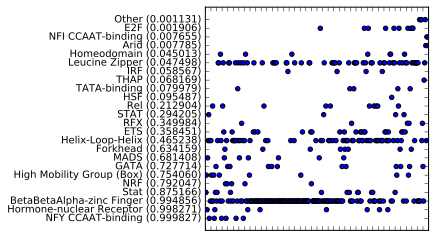

In [49]:
import matplotlib.pyplot as plt
data.loc[:, 'indx'] = range(len(data))
sorted_families = families_mww_df.sort_values('mww_corrected').index
ypos = -1
labels = ['{0} ({1:f})'.format(fam, families_mww_df.loc[fam].mww_pval)
          for fam in sorted_families]
fig = plt.figure()
axes = fig.add_subplot(111)
plt.yticks(np.arange(-1, -1 - 0.3 * len(sorted_families), -0.3), labels)
plt.xticks(range(0, len(data), 10), [])
for family in sorted_families:
    xpos = list(data[data.TF_family == family]['indx'])
    axes.scatter(xpos, [ypos] * len(xpos))
    ypos -= 0.3
plt.xlim(0, len(data))
axes.set_aspect(1./axes.get_data_ratio())
#savefig("AUROC_improvement_4bits_4bits+DNAshape_families.svg")

In [50]:
%%R -i data -i families_list -o families_mww
data = as.data.frame(data);
families_mww = data.frame(row.names=families_list);
for(family in families_list){
    inside = data[data['TF_family'] == family, 'X4bits_AUPRC_improvement'];
    outside = data[data['TF_family'] != family, 'X4bits_AUPRC_improvement'];
    if(length(inside)){
        mww = wilcox.test(inside, outside, alternative='g', exact=TRUE);
        families_mww[family, 'mww_pval'] = mww$p.value;
        families_mww[family, 'mww_corrected'] = mww$p.value * length(families_list);
        families_mww[family, 'family'] = family;
    }
}

In [51]:
families_mww_df = pd.DataFrame(families_mww[['mww_pval', 'mww_corrected']])
families_mww_df.index = families_list
families_mww_df.sort_values('mww_corrected')

,mww_pval,mww_corrected
E2F,0.000219,0.005246
Other,0.000536,0.012871
NFI CCAAT-binding,0.007655,0.183709
Arid,0.007785,0.186835
Leucine Zipper,0.032351,0.776421
RFX,0.041620,0.998879
THAP,0.048179,1.156289
ETS,0.107125,2.571002
HSF,0.122927,2.950248
TATA-binding,0.123822,2.971732


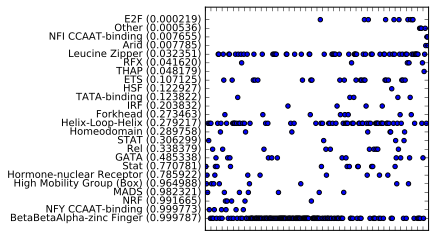

In [52]:
import matplotlib.pyplot as plt
data.loc[:, 'indx'] = range(len(data))
sorted_families = families_mww_df.sort_values('mww_corrected').index
ypos = -1
labels = ['{0} ({1:f})'.format(fam, families_mww_df.loc[fam].mww_pval)
          for fam in sorted_families]
fig = plt.figure()
axes = fig.add_subplot(111)
plt.yticks(np.arange(-1, -1 - 0.3 * len(sorted_families), -0.3), labels)
plt.xticks(range(0, len(data), 10), [])
for family in sorted_families:
    xpos = list(data[data.TF_family == family]['indx'])
    axes.scatter(xpos, [ypos] * len(xpos))
    ypos -= 0.3
plt.xlim(0, len(data))
axes.set_aspect(1./axes.get_data_ratio())
#savefig("AUPRC_improvement_4bits_4bits+DNAshape_families.svg")

# Results considering TFBS flanking sequences

In [53]:
rep = '20151103_JasparMatchedChipseqScaledDnashape2ndOrderDimo'
for repo in os.listdir(rep):
    if repo.startswith('wgEncodeAwgTfbs'):
        res_file = '{0}/{1}/predictions_results_extension_15bp.txt'.format(rep, repo)
        if os.path.isfile(res_file):
            with open(res_file) as stream:
                first_line = stream.readline()
                assert first_line.startswith('ROC AUC TFFM')
                ext_tffm_dnashape_auc = eval(first_line.split(' ')[-1])
                data.loc[repo, "ext_TFFM_dnashape_AUROC"] = ext_tffm_dnashape_auc
                data.loc[repo, "ext_TFFM_dnashape_AUROC_improvement"] = (
                    ext_tffm_dnashape_auc - data["TFFM_dnashape_AUROC"][repo])
                second_line = stream.readline()
                assert second_line.startswith('PR AUC TFFM')
                ext_tffm_dnashape_auprc = eval(second_line.split(' ')[-1])
                data.loc[repo, "ext_TFFM_dnashape_AUPRC"] = ext_tffm_dnashape_auprc
                data.loc[repo, "ext_TFFM_dnashape_AUPRC_improvement"] = (
                    ext_tffm_dnashape_auprc - data["TFFM_dnashape_AUPRC"][repo])
                third_line = stream.readline()
                assert third_line.startswith('ROC AUC PWM')
                ext_pwm_dnashape_auc = eval(third_line.split(' ')[-1])
                data.loc[repo, "ext_PSSM_dnashape_AUROC"] = ext_pwm_dnashape_auc
                data.loc[repo, "ext_PSSM_dnashape_AUROC_improvement"] = (
                    ext_pwm_dnashape_auc - data["PSSM_dnashape_AUROC"][repo])
                fourth_line = stream.readline()
                assert fourth_line.startswith('PR AUC PWM')
                ext_pwm_dnashape_auprc = eval(fourth_line.split(' ')[-1])
                data.loc[repo, 'ext_PSSM_dnashape_AUPRC'] = ext_pwm_dnashape_auprc
                data.loc[repo, 'ext_PSSM_dnashape_AUPRC_improvement'] = (
                    ext_pwm_dnashape_auprc - data['PSSM_dnashape_AUPRC'][repo])

In [54]:
rep = '20160416_JasparMatchedChipseq1merScaledDnashape2ndorderDimoGradboost'
for repo in os.listdir(rep):
    if repo.startswith('wgEncodeAwgTfbs'):
        res_file = '{0}/{1}/predictions_results_extension_15bp.txt'.format(rep, repo)
        if os.path.isfile(res_file):
            with open(res_file) as stream:
                first_line = stream.readline()
                assert first_line.startswith('ROC AUC 1mer+DNAshape')
                data.loc[repo, 'ext_4bits_dnashape_AUROC'] = auc_val(first_line)
                second_line = stream.readline()
                assert second_line.startswith('PR AUC 1mer+DNAshape')
                data.loc[repo, 'ext_4bits_dnashape_AUPRC'] = auc_val(second_line)
                data.loc[repo, 'ext_4bits_AUPRC_improvement'] = (
                    data.loc[repo,'ext_4bits_dnashape_AUPRC'] -
                    data.loc[repo, '4bits_dnashape_AUPRC'])
                data.loc[repo, 'ext_4bits_AUROC_improvement'] = (
                    data.loc[repo,'ext_4bits_dnashape_AUROC'] -
                    data.loc[repo, '4bits_dnashape_AUROC']) 

## TFFM results on all ChIP-seq experiments

In [55]:
print "TFFM-based classifier using the 15bp extension is superior in {0:d} over {1:d} cases".format(
    len(data[data["ext_TFFM_dnashape_AUROC"] > data["TFFM_dnashape_AUROC"]]), len(data.dropna()))
print "TFFM-based classifier using the 15bp extension is superior in {0:d} over {1:d} cases".format(
    len(data[data["ext_TFFM_dnashape_AUPRC"] > data["TFFM_dnashape_AUPRC"]]), len(data.dropna()))

TFFM-based classifier using the 15bp extension is superior in 384 over 400 cases
TFFM-based classifier using the 15bp extension is superior in 373 over 400 cases


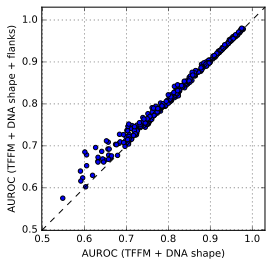

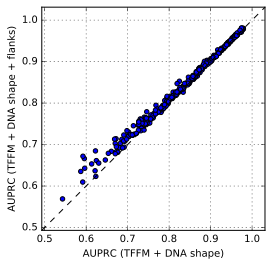

In [56]:
mini = min(min(data["ext_TFFM_dnashape_AUROC"]), min(data["TFFM_dnashape_AUROC"])) - 0.05
maxi = max(max(data["ext_TFFM_dnashape_AUROC"]), max(data["TFFM_dnashape_AUROC"])) + 0.05
axes = data.dropna().plot(y="ext_TFFM_dnashape_AUROC", x="TFFM_dnashape_AUROC", kind="scatter")
axes.set_ylabel("AUROC (TFFM + DNA shape + flanks)")
axes.set_xlabel("AUROC (TFFM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_ylim(mini, maxi)
axes.set_xlim(mini, maxi)
axes.set_aspect('equal')
axes.grid()
#savefig("AUROC_ext_TFFM+DNAshape_TFFM+DNAshape.svg")

mini = min(min(data["ext_TFFM_dnashape_AUPRC"]), min(data["TFFM_dnashape_AUPRC"])) - 0.05
maxi = max(max(data["ext_TFFM_dnashape_AUPRC"]), max(data["TFFM_dnashape_AUPRC"])) + 0.05
axes = data.dropna().plot(y="ext_TFFM_dnashape_AUPRC", x="TFFM_dnashape_AUPRC", kind="scatter")
axes.set_ylabel("AUPRC (TFFM + DNA shape + flanks)")
axes.set_xlabel("AUPRC (TFFM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_ylim(mini, maxi)
axes.set_xlim(mini, maxi)
axes.set_aspect('equal')
axes.grid()
#savefig("AUPRC_ext_TFFM+DNAshape_TFFM+DNAshape.svg")

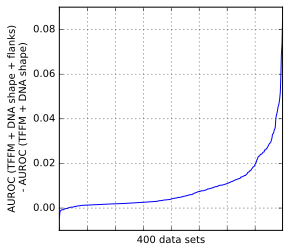

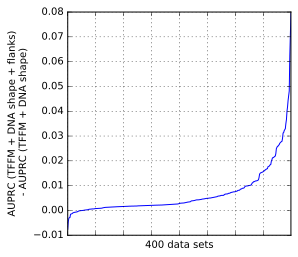

In [57]:
data = data.sort_values("ext_TFFM_dnashape_AUROC_improvement")
axes = data.dropna().plot(y="ext_TFFM_dnashape_AUROC_improvement", use_index=False, legend=False)
axes.tick_params(axis="x", labelbottom='off')
axes.set_xlabel("{0:d} data sets".format(len(data.dropna())))
axes.set_ylabel("AUROC (TFFM + DNA shape + flanks)\n - AUROC (TFFM + DNA shape)")
axes.set_aspect(1./axes.get_data_ratio())
axes.grid()
#savefig("AUROC_improvement_ext_TFFM+DNAshape_TFFM+DNAshape.svg")

data = data.sort_values("ext_TFFM_dnashape_AUPRC_improvement")
axes = data.dropna().plot(y="ext_TFFM_dnashape_AUPRC_improvement", use_index=False, legend=False)
axes.tick_params(axis="x", labelbottom='off')
axes.set_xlabel("{0:d} data sets".format(len(data.dropna())))
axes.set_ylabel("AUPRC (TFFM + DNA shape + flanks)\n - AUPRC (TFFM + DNA shape)")
axes.set_aspect(1./axes.get_data_ratio())
axes.grid()
#savefig("AUPRC_improvement_ext_TFFM+DNAshape_TFFM+DNAshape.svg")

## PSSM results on all ChIP-seq experiments

In [58]:
print "PSSM-based classifiers using the 15bp extension is superior in {0:d} over {1:d} cases".format(
    len(data[data["ext_PSSM_dnashape_AUROC"] > data["PSSM_dnashape_AUROC"]]), len(data.dropna()))
print "PSSM-based classifiers using the 15bp extension is superior in {0:d} over {1:d} cases".format(
    len(data[data["ext_PSSM_dnashape_AUPRC"] > data["PSSM_dnashape_AUPRC"]]), len(data.dropna()))

PSSM-based classifiers using the 15bp extension is superior in 388 over 400 cases
PSSM-based classifiers using the 15bp extension is superior in 378 over 400 cases


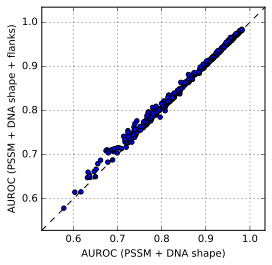

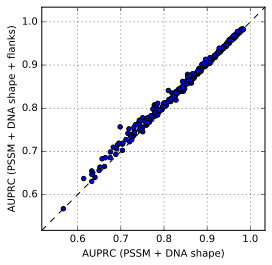

In [59]:
mini = min(min(data["ext_PSSM_dnashape_AUROC"]), min(data["PSSM_dnashape_AUROC"])) - 0.05
maxi = max(max(data["ext_PSSM_dnashape_AUROC"]), max(data["PSSM_dnashape_AUROC"])) + 0.05
axes = data.dropna().plot(y="ext_PSSM_dnashape_AUROC", x="PSSM_dnashape_AUROC", kind="scatter")
axes.set_ylabel("AUROC (PSSM + DNA shape + flanks)")
axes.set_xlabel("AUROC (PSSM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_ylim(mini, maxi)
axes.set_xlim(mini, maxi)
axes.set_aspect('equal')
axes.grid()
#savefig("AUROC_ext_PSSM+DNAshape_PSSM+DNAshape.svg")

mini = min(min(data["ext_PSSM_dnashape_AUPRC"]), min(data["PSSM_dnashape_AUPRC"])) - 0.05
maxi = max(max(data["ext_PSSM_dnashape_AUPRC"]), max(data["PSSM_dnashape_AUPRC"])) + 0.05
axes = data.dropna().plot(y="ext_PSSM_dnashape_AUPRC", x="PSSM_dnashape_AUPRC", kind="scatter")
axes.set_ylabel("AUPRC (PSSM + DNA shape + flanks)")
axes.set_xlabel("AUPRC (PSSM + DNA shape)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_ylim(mini, maxi)
axes.set_xlim(mini, maxi)
axes.set_aspect('equal')
axes.grid()
#savefig("AUPRC_ext_PSSM+DNAshape_PSSM+DNAshape.svg")

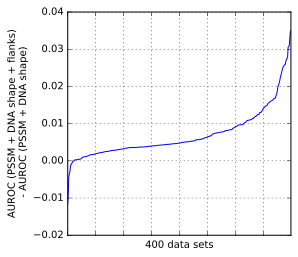

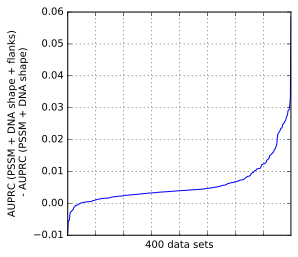

In [60]:
data = data.sort_values("ext_PSSM_dnashape_AUROC_improvement")
axes = data.dropna().plot(y="ext_PSSM_dnashape_AUROC_improvement", use_index=False, legend=False)
axes.tick_params(axis="x", labelbottom='off')
axes.set_xlabel("{0:d} data sets".format(len(data.dropna())))
axes.set_ylabel("AUROC (PSSM + DNA shape + flanks)\n - AUROC (PSSM + DNA shape)")
axes.set_aspect(1./axes.get_data_ratio())
axes.grid()
#savefig("AUROC_improvement_ext_PSSM+DNAshape_PSSM+DNAshape.svg")

data = data.sort_values("ext_PSSM_dnashape_AUPRC_improvement")
axes = data.dropna().plot(y="ext_PSSM_dnashape_AUPRC_improvement", use_index=False, legend=False)
axes.tick_params(axis="x", labelbottom='off')
axes.set_xlabel("{0:d} data sets".format(len(data.dropna())))
axes.set_ylabel("AUPRC (PSSM + DNA shape + flanks)\n - AUPRC (PSSM + DNA shape)")
axes.set_aspect(1./axes.get_data_ratio())
axes.grid()
#savefig("AUPRC_improvement_ext_PSSM+DNAshape_PSSM+DNAshape.svg")

## 4-bits results on all ChIP-seq experiments

In [61]:
print "4bits-based classifiers have higher AUROC in {0:d} over {1:d} cases".format(
    len(data[data["ext_4bits_dnashape_AUROC"] > data["4bits_dnashape_AUROC"]]),
    len(data.dropna()))
print "4bits-based classifiers have higher AUPRC in {0:d} over {1:d} cases".format(
    len(data[data["ext_4bits_dnashape_AUPRC"] > data["4bits_dnashape_AUPRC"]]),
    len(data.dropna()))

4bits-based classifiers have higher AUROC in 388 over 400 cases
4bits-based classifiers have higher AUPRC in 375 over 400 cases


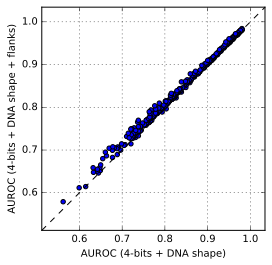

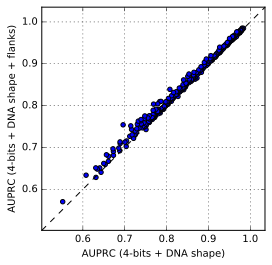

In [62]:
mini = min(min(data.dropna()["ext_4bits_dnashape_AUROC"]),
           min(data.dropna()["4bits_dnashape_AUROC"])) - 0.05
maxi = max(max(data.dropna()["ext_4bits_dnashape_AUROC"]),
           max(data.dropna()["4bits_dnashape_AUROC"])) + 0.05
axes = data.dropna().plot(x="4bits_dnashape_AUROC", y="ext_4bits_dnashape_AUROC",
                          kind="scatter")
axes.set_xlabel("AUROC (4-bits + DNA shape)")
axes.set_ylabel("AUROC (4-bits + DNA shape + flanks)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
axes.grid()
#savefig("AUROC_4bits+DNAshape_4bits+extDNAshape.svg")

mini = min(min(data.dropna()["ext_4bits_dnashape_AUPRC"]),
           min(data.dropna()["4bits_dnashape_AUPRC"])) - 0.05
maxi = max(max(data.dropna()["ext_4bits_dnashape_AUPRC"]),
           max(data.dropna()["4bits_dnashape_AUPRC"])) + 0.05
axes = data.dropna().plot(x="4bits_dnashape_AUPRC", y="ext_4bits_dnashape_AUPRC",
                          kind="scatter")
axes.set_xlabel("AUPRC (4-bits + DNA shape)")
axes.set_ylabel("AUPRC (4-bits + DNA shape + flanks)")
axes.plot((mini, maxi), (mini, maxi), 'k--')
axes.set_xlim(mini, maxi)
axes.set_ylim(mini, maxi)
axes.set_aspect('equal')
axes.grid()
#savefig("AUPRC_4bits+DNAshape_4bits+extDNAshape.svg")

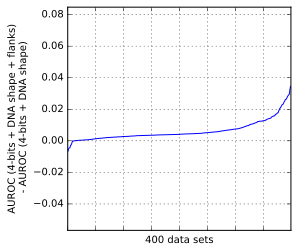

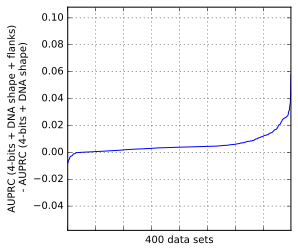

In [63]:
data = data.sort_values("ext_4bits_AUROC_improvement")
axes = data.dropna().plot(y="ext_4bits_AUROC_improvement", use_index=False, legend=False)
axes.tick_params(axis="x", labelbottom='off')
axes.set_xlabel("{0:d} data sets".format(len(data.dropna())))
axes.set_ylabel("AUROC (4-bits + DNA shape + flanks)\n - AUROC (4-bits + DNA shape)")
axes.set_ylim(min(data['ext_4bits_AUROC_improvement']) - 0.05,
              max(data['ext_4bits_AUROC_improvement']) + 0.05)
axes.set_aspect(1./axes.get_data_ratio())
axes.grid()
#savefig("AUROC_improvement_ext_4bits+DNAshape.svg")

data = data.sort_values("ext_4bits_AUPRC_improvement")
axes = data.dropna().plot(y="ext_4bits_AUPRC_improvement", use_index=False, legend=False)
axes.tick_params(axis="x", labelbottom='off')
axes.set_xlabel("{0:d} data sets".format(len(data.dropna())))
axes.set_ylabel("AUPRC (4-bits + DNA shape + flanks)\n - AUPRC (4-bits + DNA shape)")
axes.set_ylim(min(data['ext_4bits_AUPRC_improvement']) - 0.05,
              max(data['ext_4bits_AUPRC_improvement']) + 0.05)
axes.set_aspect(1./axes.get_data_ratio())
axes.grid()
#savefig("AUPRC_improvement_ext_4bits+DNAshape.svg")